In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import statsmodels.api as sm

### Acknowlegment:

This following series of notebooks use directly the datasets and logic provided by Johannes Mauritzen on his github page (https://jmaurit.github.io/). I follow his methods closely. The series of lectures, which inspired my notebooks use the R language, so I instead adapted his methodology into Python myself. This acknolegments page applies to all subsequent notebooks on this repository. The choice of `.ipynb` felt more natural and easier than an Object Oriented approach, as the latter is not necessary here. 

## Accounting Data for Petroleum Firms

Analysing data set of Norwegian oil and gas firms 

A turbulent period for oil and gas industry in Norway is explored to spot any trends.

After 2012, oil prices fell sharply following the shale revolution, or "fracking", which forced a major restructuring in the Norwegian oil and gas industry. 

Does this restructuring have anything to teach us about the future of oil and gas, both in Norway and the world? What potential "shocks" does the industry face? What would be the effects of government policy?

In [5]:
adf = pd.read_csv("adf.csv")

/var/folders/g2/l186zykd1g56mc9vp1p2rv280000gn/T/ipykernel_43234/2160774049.py:1: DtypeWarning: Columns (34,35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  adf = pd.read_csv("adf.csv")


In [6]:
adf.drop(columns='Unnamed: 0', inplace=True)

Cleaning the data

In [7]:
# replace the norwegian names 

# English translations
new_names = [
  "working_capital", "working_capital_perc", "fixed_assets", "long_debt", 
  "NACE_desc", "NACE_code", "profit", "other_fin_instr", "employees", 
  "depreciation", "change_inventories", "operating_income", "operating_costs", 
  "operating_result", "equity", "total_assets", "org_type", "principality", 
  "debt", "inv", "cash", "municipality", "corp_accounts", "short_debt", 
  "accounts_receivable", "director", "liquidity", "wage_costs", "profitability", 
  "current_assets", "pretax_profit", "orgnr", "audit_remarks", "audit_komments", 
  "audit_explanation_txt", "audit_explanation", "sales_revenue", "solidity", 
  "status", "founded_date", "dividend", "currency_code", "supply_cost", 
  "inventory", "year", "name"
]


# Replace column names in your DataFrame
adf.columns = new_names


In [324]:
adf.head()

,working_capital,working_capital_perc,fixed_assets,long_debt,NACE_desc,NACE_code,profit,other_fin_instr,employees,depreciation,...,sales_revenue,solidity,status,founded_date,dividend,currency_code,supply_cost,inventory,year,name
0,4579000.0,0.009905,446456000.0,250917000.0,Utvinning av råolje,6.1,18313000.0,NaN,18143.0,46596000.0,...,462292000.0,35.555042,Aktivt,1972-09-18,19100000.0,NOK,205870000.0,20196000.0,2009,STATOIL ASA
1,48294000.0,0.091689,449356000.0,271255000.0,Utvinning av råolje,6.1,38082000.0,NaN,18143.0,NaN,...,526718000.0,35.208738,Aktivt,1972-09-18,NaN,NOK,228328000.0,23627000.0,2010,STATOIL ASA
2,26959000.0,0.041758,570519000.0,312323000.0,Utvinning av råolje,6.1,78787000.0,NaN,18143.0,50200000.0,...,645599000.0,37.100235,Aktivt,1972-09-18,NaN,NOK,319605000.0,27770000.0,2011,STATOIL ASA
3,19500000.0,0.027632,601400000.0,301000000.0,Utvinning av råolje,6.1,69500000.0,NaN,18143.0,60500000.0,...,705700000.0,40.782764,Aktivt,1972-09-18,NaN,NOK,363100000.0,25300000.0,2012,STATOIL ASA
4,71900000.0,0.116080,646800000.0,362700000.0,Utvinning av råolje,6.1,39300000.0,NaN,18143.0,72400000.0,...,619400000.0,40.198735,Aktivt,1972-09-18,NaN,NOK,307500000.0,29600000.0,2013,STATOIL ASA


NACE is the European standard for industry sector. It is composed of a main sector (e.g. 6: oil and gas extraction) and sub-sector (e.g. .2: extraction of natural gas). Both main and sub sector codes are found in the `NACE_industry_code` column and need to be separated

In [325]:
adf["NACE_code"]

0          6.100
1          6.100
2          6.100
3          6.100
4          6.100
           ...  
129890    85.201
129891    85.201
129892    85.201
129893    85.201
129894    85.201
Name: NACE_code, Length: 129895, dtype: float64

In [326]:
adf['NACE_code'].unique()

array([ 6.1  , 70.1  , 84.12 , 65.11 , 64.19 , 24.421, 46.39 , 65.12 ,
       92.   ,  6.2  , 53.1  , 46.71 , 61.2  , 51.1  , 10.51 , 10.11 ,
       20.3  , 49.1  , 20.13 , 46.21 , 47.251,  3.211, 45.111, 52.23 ,
       45.191, 20.15 , 47.111, 86.101, 30.113, 46.381, 35.111, 41.2  ,
       41.101,  9.109, 33.2  , 47.73 , 47.54 , 46.46 , 28.221, 30.111,
       62.03 , 71.2  , 52.219, 47.591, 10.209, 26.51 , 62.02 , 46.732,
       27.32 , 42.13 , 71.129, 46.74 , 10.91 , 35.12 , 21.1  ,  9.101,
       60.2  , 49.311, 45.2  , 25.4  , 10.202, 10.13 , 24.102, 28.92 ,
       20.16 , 81.21 , 46.31 , 47.71 , 46.51 , 80.2  , 47.521, 42.11 ,
       23.99 , 71.121, 35.13 , 52.291, 68.209, 35.14 , 46.349, 71.122,
       47.641, 24.422, 43.21 , 47.19 , 46.9  , 32.5  , 43.221, 72.19 ,
       33.15 , 28.13 , 77.4  , 20.14 , 82.99 , 45.112, 88.995, 46.63 ,
       61.1  , 69.202, 46.739, 28.12 , 46.691, 27.4  , 64.201, 27.11 ,
       46.494, 11.07 , 21.2  , 50.102, 33.16 , 47.761, 20.41 , 24.101,
      

Modify the `NACE_industry_code` column is changed from `float64` to type `str`. Split the column into main and sub sector columns. Ensure that small floating-point errors are hidden. If we simply use `.astype(str)` converts all values to a string representation. This conversion retains their full precision, which can lead to long decimal values. 

In [8]:
adf['NACE_code'] = adf['NACE_code'].apply(lambda x: f"{x:.3f}" if pd.notnull(x) else x)

In [9]:
# .str accessor enables vectorised string operations across all elements of Series
adf[['NACE1', 'NACE2']] = adf['NACE_code'].str.split('.', expand=True)

Values of `NACE1` are examined to ensure they are valid

In [329]:
adf['NACE1'].unique()

array(['6', '70', '84', '65', '64', '24', '46', '92', '53', '61', '51',
       '10', '20', '49', '47', '3', '45', '52', '86', '30', '35', '41',
       '9', '33', '28', '62', '71', '26', '27', '42', '21', '60', '25',
       '81', '80', '23', '68', '43', '32', '72', '77', '82', '88', '69',
       '11', '50', '17', '55', '78', '38', '58', '16', '87', '56', '66',
       '94', '85', '31', '29', '22', '93', '73', '8', '96', '7', '14',
       '90', '63', '95', '36', '5', '18', '59', '13', '2', '1', '91',
       '79', '74', '37', '75', '0', '19'], dtype=object)

The NACE system starts at 1, so 0 values (still in `str` format) should be removed

In [10]:
adf = adf[adf['NACE1'] != '0']

There are many missing values. We see there are consistely around 90k values missing in certain columns, we must investigate origin of such errors. Let's verify whether a certain year contains more missing values than others.

In [331]:
adf.isna().sum()

working_capital           90604
working_capital_perc      91140
fixed_assets              90603
long_debt                 90604
NACE_desc                     0
NACE_code                     0
profit                    90696
other_fin_instr          128330
employees                     0
depreciation              90966
change_inventories        91420
operating_income          90603
operating_costs           90603
operating_result          90603
equity                    90603
total_assets              90603
org_type                      0
principality                335
debt                      90603
inv                       90686
cash                      96250
municipality                335
corp_accounts             90603
short_debt                90604
accounts_receivable       92800
director                  70693
liquidity                 90785
wage_costs                90953
profitability             90634
current_assets            90603
pretax_profit             90603
orgnr   

Each of the 7 years is verified, perhaps one of the years has all data missing

In [332]:
adf['year'].unique()

array([2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016])

In [333]:
adf[adf['year']==2016]

,working_capital,working_capital_perc,fixed_assets,long_debt,NACE_desc,NACE_code,profit,other_fin_instr,employees,depreciation,...,status,founded_date,dividend,currency_code,supply_cost,inventory,year,name,NACE1,NACE2
53382,NaN,NaN,NaN,NaN,Hovedkontortjenester,70.100,NaN,NaN,92.0,NaN,...,Aktivt,2012-10-14,NaN,NaN,NaN,NaN,2016,NaN,70,100
53390,NaN,NaN,NaN,NaN,Hovedkontortjenester,70.100,NaN,NaN,59.0,NaN,...,Aktivt,1992-05-18,NaN,NaN,NaN,NaN,2016,MARINE HARVEST ASA,70,100
53398,NaN,NaN,NaN,NaN,Offentlig administrasjon tilknyttet helsestell...,84.120,NaN,NaN,67.0,NaN,...,Aktivt,2001-08-17,NaN,NaN,NaN,NaN,2016,HELSE VEST RHF,84,120
53406,NaN,NaN,NaN,NaN,Hovedkontortjenester,70.100,NaN,NaN,58.0,NaN,...,Aktivt,1987-06-19,NaN,NaN,NaN,NaN,2016,KONGSBERG GRUPPEN ASA,70,100
53414,NaN,NaN,NaN,NaN,Hovedkontortjenester,70.100,NaN,NaN,91.0,NaN,...,Aktivt,1953-11-26,NaN,NaN,NaN,NaN,2016,SCHIBSTED ASA,70,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129862,NaN,NaN,NaN,NaN,Ordinær grunnskoleundervisning,85.201,NaN,NaN,64.0,NaN,...,Underavd.,NaN,NaN,NaN,NaN,NaN,2016,NaN,85,201
129870,NaN,NaN,NaN,NaN,Offentlig administrasjon tilknyttet helsestell...,84.120,NaN,NaN,75.0,NaN,...,Underavd.,NaN,NaN,NaN,NaN,NaN,2016,NaN,84,120
129878,NaN,NaN,NaN,NaN,Ordinær grunnskoleundervisning,85.201,NaN,NaN,67.0,NaN,...,Underavd.,NaN,NaN,NaN,NaN,NaN,2016,NaN,85,201
129886,NaN,NaN,NaN,NaN,Ordinær grunnskoleundervisning,85.201,NaN,NaN,69.0,NaN,...,Underavd.,NaN,NaN,NaN,NaN,NaN,2016,NaN,85,201


Drop 2016 as all data is missing

In [11]:
adf = adf[adf['year']!=2016]

We can drop the columns, which contain the most missing values

In [335]:
adf.isna().sum()

working_capital           81101
working_capital_perc      81636
fixed_assets              81100
long_debt                 81101
NACE_desc                     0
NACE_code                     0
profit                    81192
other_fin_instr          118771
employees                     0
depreciation              81462
change_inventories        81916
operating_income          81100
operating_costs           81100
operating_result          81100
equity                    81100
total_assets              81100
org_type                      0
principality                308
debt                      81100
inv                       81182
cash                      86746
municipality                308
corp_accounts             81100
short_debt                81101
accounts_receivable       83295
director                  64932
liquidity                 81282
wage_costs                81449
profitability             81131
current_assets            81100
pretax_profit             81100
orgnr   

Removing entire columns containing many NaN values is inappropriate because some figures are only reported by certain companies on certain years

### Split dataframe into entire groups and perform calcumations on said groups

e.g. sum of revenues, profits, costs for all main sectors (NACE1) and for each year

In [337]:
sum_adf = (adf.groupby(['NACE1', 'year'])
           .agg(
               total_income=('operating_income', 'sum'),
               total_result=('operating_result', 'sum'),
               total_costs=('operating_costs', 'sum'),
               total_wages=('wage_costs', 'sum')

            ).reset_index()
)

In [339]:
sum_adf.head()

,NACE1,year,total_income,total_result,total_costs,total_wages
0,1,2009,1862945.0,20103.0,1842846.0,1209569.0
1,1,2010,2048207.0,5557.0,2042654.0,1332220.0
2,1,2011,2296387.0,-2771.0,2299162.0,1540094.0
3,1,2012,2473189.0,74522.0,2398665.0,1618666.0
4,1,2013,2614102.0,31576.0,2582531.0,1758487.0


Filter `sum_adf` to only keep the 2015 year

In [340]:
sum_adf15 = sum_adf[sum_adf['year']==2015]

Let's unpivot the DataFrame from wide to long format. `pd.melt()` allows for one or more columns to be an identifier variable, while other columns (measured variables) are unpivoted to the row axis.

In [341]:
sum_adf15_long = pd.melt(
    sum_adf15, 
    id_vars=['NACE1', 'year'],
    value_vars=['total_income', 'total_result', 'total_costs', 'total_wages'],
    var_name='variable',
    value_name='value'
)

In [342]:
sum_adf15_long

,NACE1,year,variable,value
0,1,2015,total_income,2874254.0
1,10,2015,total_income,151318372.0
2,11,2015,total_income,7321582.0
3,13,2015,total_income,2616948.0
4,14,2015,total_income,1442371.0
...,...,...,...,...
323,92,2015,total_wages,815238.0
324,93,2015,total_wages,2379776.0
325,94,2015,total_wages,9471485.0
326,95,2015,total_wages,357022.0


Total income is looked at by sector

In [343]:
income15 = sum_adf15_long[sum_adf15_long['variable'] == 'total_income']

In [345]:
income15.head()

,NACE1,year,variable,value
0,1,2015,total_income,2874254.0
1,10,2015,total_income,151318372.0
2,11,2015,total_income,7321582.0
3,13,2015,total_income,2616948.0
4,14,2015,total_income,1442371.0


In [346]:
income15.sort_values(by='value', ascending=False).head()

,NACE1,year,variable,value
56,70,2015,total_income,742773466.0
45,6,2015,total_income,601603659.0
33,46,2015,total_income,453133370.0
51,65,2015,total_income,264872565.0
34,47,2015,total_income,252881582.0


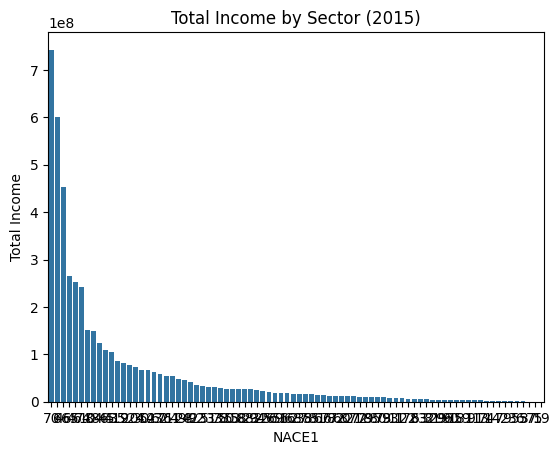

In [347]:
sns.barplot(data=income15.sort_values(by='value', ascending=False), x='NACE1', y='value')
plt.title('Total Income by Sector (2015)')
plt.xlabel('NACE1')
plt.ylabel('Total Income')
plt.show()

In [348]:
# sort the long format sum_adf15_long
sorted_data = (
    sum_adf15_long
    .sort_values(by=["variable", "value"], ascending=[True, False])
)

/var/folders/g2/l186zykd1g56mc9vp1p2rv280000gn/T/ipykernel_27010/907667993.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
/var/folders/g2/l186zykd1g56mc9vp1p2rv280000gn/T/ipykernel_27010/907667993.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


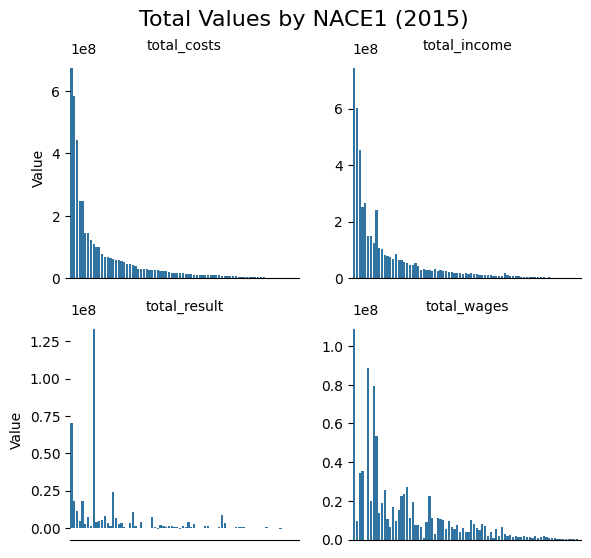

In [349]:
g = sns.FacetGrid(
    sorted_data,
    col="variable",
    col_wrap=2,
    sharey=False
)

# map bar plot to each subplot
g.map(sns.barplot, "NACE1", "value", order=sorted_data["NACE1"].unique())

for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# Adjust spacing and aesthetics
g.fig.subplots_adjust(top=0.9)  # Adjust top space
g.fig.suptitle('Total Values by NACE1 (2015)', fontsize=16)  # Add title
g.set_axis_labels("", "Value")  # Set common axis labels
g.set_titles("{col_name}")  # Set column titles
g.set(xticks=[])  # Remove x-axis ticks
g.despine(left=True)  # Remove left spine for cleaner look

plt.show()

The NACE1 (main sector) variable is used here as the independent variable (x). 

TRY: order all variables by income (descending order)

In [112]:
# Sort the data by total_income in descending order
income_order = (
    sum_adf15_long[sum_adf15_long['variable'] == 'total_income']
    .sort_values(by='value', ascending=False)
    ['NACE1']
    .unique()
)


/var/folders/g2/l186zykd1g56mc9vp1p2rv280000gn/T/ipykernel_27010/3284283723.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
/var/folders/g2/l186zykd1g56mc9vp1p2rv280000gn/T/ipykernel_27010/3284283723.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


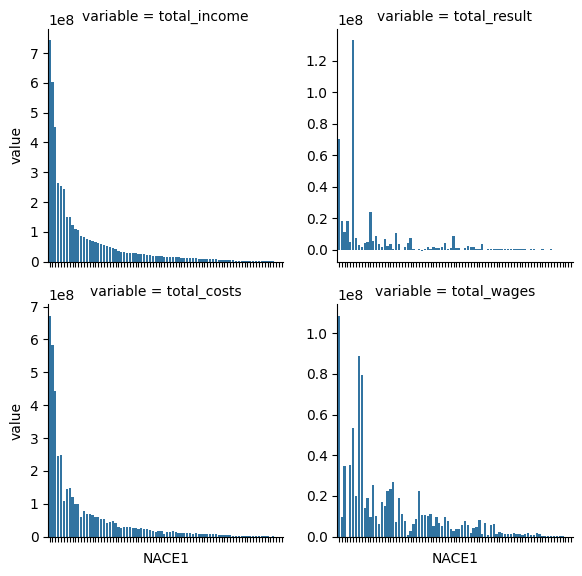

In [113]:
# use this global order in all other variables
# Create subplots with consistent global ordering
g = sns.FacetGrid(
    sum_adf15_long, 
    col="variable", 
    col_wrap=2, 
    sharey=False
)
g.map_dataframe(
    sns.barplot, 
    x="NACE1", 
    y="value", 
    order=income_order  # Use the global order based on total_income
)

# Rotate x-axis labels for readability
for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.show()


Here let us look at the 10 largest industrial sectors by income (2015 only)

In [135]:
income15.sort_values(by='value', ascending=False)[:10]['NACE1'].tolist()

['70', '6', '46', '65', '47', '64', '10', '84', '86', '45']

The largest sector is **70** (activities of head offices, management consultancy services), 2nd largest is **6** (Extraction of crude petroleum and natural gas), 3rd largest is **46** (Wholesale trade, except of motor vehicles and motorcycles). Largest sector in the Norwegian industry is office work. 

Now the same approach is taken with the highest profit industries.

In [138]:
result15 = sum_adf15_long.query('variable == "total_result"')

In [146]:
top4_res = result15.sort_values(by='value', ascending=False)['NACE1'][:4].tolist()

The most profitable industry is 64 (financial service activities) following by 70 (activities of head offices). The oil and gas industry is only the fourth most profitable industry. Top 4 main sectors are saved as list `top4_res` in `str` format.

The results (profits) are plotted over time for the top 4 profitable industries using the `sum_adf` DataFrame where all companies income, result, costs and wages are summed per main sector `NACE1`.

In [145]:
sum_adf

,NACE1,Year,total_income,total_result,total_costs,total_wages
0,1,2009,1862945.0,20103.0,1842846.0,1209569.0
1,1,2010,2048207.0,5557.0,2042654.0,1332220.0
2,1,2011,2296387.0,-2771.0,2299162.0,1540094.0
3,1,2012,2473189.0,74522.0,2398665.0,1618666.0
4,1,2013,2614102.0,31576.0,2582531.0,1758487.0
...,...,...,...,...,...,...
569,96,2011,2456451.0,166001.0,2290449.0,1062448.0
570,96,2012,2689728.0,232714.0,2457014.0,1168744.0
571,96,2013,2865318.0,226835.0,2638486.0,1274155.0
572,96,2014,3035315.0,279393.0,2755919.0,1345824.0


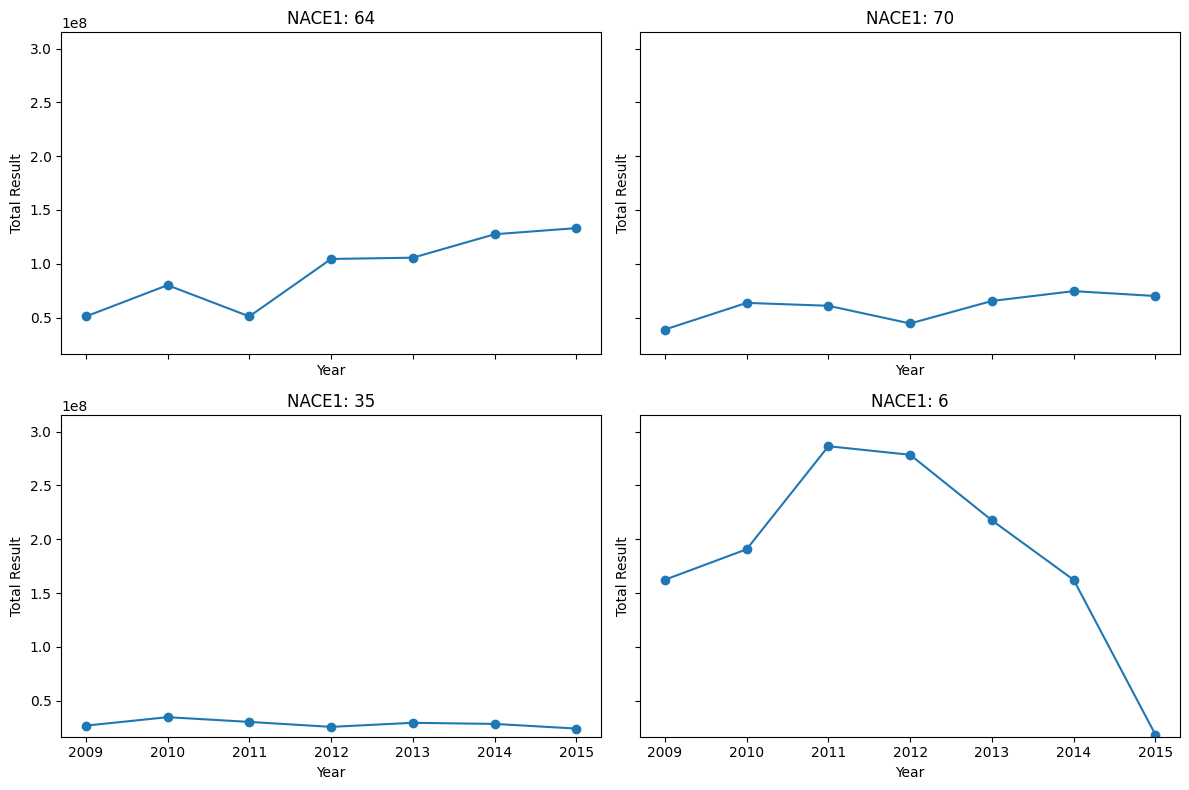

In [150]:
# select rows in sum_adf where NACE1 is in top4_res
top4_data = sum_adf[sum_adf['NACE1'].isin(top4_res)]

# use plt.subplots() to create 4 subplots, one for each NACE1 in top4_res
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharey=True, sharex=True)
axes = axes.flatten()

# plot total_result vs Year for each NACE1
for i, nace in enumerate(top4_res):
    nace_data = top4_data[top4_data['NACE1'] == nace]
    axes[i].plot(nace_data['Year'], nace_data['total_result'], marker='o')
    axes[i].set_title(f'NACE1: {nace}')
    axes[i].set_xlabel('Year')
    axes[i].set_ylabel('Total Result')
    axes[i].set_ylim(nace_data['total_result'].min() * 0.9,
                     nace_data['total_result'].max() * 1.1)
plt.tight_layout()
plt.show()

It appears as though Financial services (64) and Head office/ consultancy activities (70) performed well over the time period considered (2009-2015). On the other hand, it appears that o&g companies hit peak profitability in 2011. It'd be interesting to understand the main drivers behind these trends. 

It'd therefore be interesting to study which individual companies are the most profitable in each main sector. This data is found in the `adf` DataFrame created earlier containing data for all individual companies per year.

In [353]:
adf_ranked = adf.groupby(['NACE1', 'year']) \
    .apply(lambda x: x.assign(ranking=x['operating_result'].rank(ascending=False))) \
    .reset_index(drop=True)

/var/folders/g2/l186zykd1g56mc9vp1p2rv280000gn/T/ipykernel_27010/1658805407.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.assign(ranking=x['operating_result'].rank(ascending=False))) \


In [354]:
print(adf[adf['name'] == 'STATOIL ASA']['operating_result'])
print(adf[adf['name'] == 'GENO SA']['operating_result'])

0    121640000.0
1    137228000.0
2    211784000.0
3    206600000.0
4    155500000.0
5    109460000.0
6     14904000.0
Name: operating_result, dtype: float64
7994     7307.0
7995     3560.0
7996    -4207.0
7997    -4572.0
7998    -3770.0
7999    -3490.0
8000    13453.0
Name: operating_result, dtype: float64


Note that with `min_rank`, by default, equal values are assigned a rank that is the average of the ranks of those values (e.g. 7.5 value seen above)

The company with the most *total profits* in each main sector in 2015 is included in `most_profit_2015` DataFrame

In [355]:
#boolean
most_profit_2015 = adf_ranked[(adf_ranked['ranking'] == 1) & (adf_ranked['year'] == 2015)]
print(most_profit_2015[['name', 'NACE_desc']])

                                name  \
816                          GENO SA   
3046                         TINE SA   
3517        HANSA BORG BRYGGERIER AS   
3649                 EGERSUND NET AS   
3717            HANSEN PROTECTION AS   
...                              ...   
115855              NORSK TIPPING AS   
117876              SKISTAR NORGE AS   
119812                REGNSKOGFONDET   
119995             INFOCARE NORGE AS   
120254  BERENDSEN TEKSTIL SERVICE AS   

                                                NACE_desc  
816                       Tjenester tilknyttet husdyrhold  
3046                            Produksjon av meierivarer  
3517                                     Produksjon av øl  
3649                        Produksjon av tauverk og nett  
3717                Produksjon av klær og tilbehør ellers  
...                                                   ...  
115855                        Lotteri og totalisatorspill  
117876                             Drif

In [356]:
most_profit_2015.sort_values(by='operating_result', ascending=False)[['name', 'NACE1', 'NACE_desc', 'operating_result']]

,name,NACE1,NACE_desc,operating_result
44348,DNB BANK ASA,64,Bankvirksomhet ellers,33253000.0
47985,TELENOR ASA,70,Hovedkontortjenester,22760000.0
40915,STATOIL ASA,6,Utvinning av råolje,14904000.0
41541,TELENOR NORGE AS,61,Trådløs telekommunikasjon,7000000.0
11730,STATKRAFT ENERGI AS,35,Produksjon av elektrisitet fra vannkraft,6338000.0
...,...,...,...,...
11987,MILJØSERVICE AS,37,Oppsamling og behandling av avløpsvann,17551.0
816,GENO SA,1,Tjenester tilknyttet husdyrhold,13453.0
115251,NYTT KONSERTHUS I STAVANGER IKS,90,Tjenester tilknyttet underholdningsvirksomhet,9691.0
51250,NaN,75,Veterinærtjenester,1817.0


The most profitable firm of most profitable firms per main sectors appears to be `DNB BANK ASA`, followed by `TELENOR ASA` and `STATOIL ASA` in third position.

An improved metric over total profit would be *profit margins*, a metric we could calculate as the ratio $\frac{\text{Operating result}}{\text{Operating revenue}}$

- The oil and gas firms are kept (by keeping NACE1==6)

In [12]:
adf_OG = adf[adf['NACE1']=='6']

- only `ASA` (listed stock companies) and `SA` (Stock companies) are kept

In [13]:
adf_OG = adf_OG[adf_OG['org_type'].isin(['ASA', 'AS'])]

In [430]:
adf_OG['name'].unique()

array(['STATOIL ASA', 'TOTAL E&P NORGE AS', 'A/S Norske Shell',
       'ENI NORGE AS', 'GDF SUEZ E&P NORGE AS', 'RWE DEA NORGE AS',
       'LUNDIN NORWAY AS', 'DET NORSKE OLJESELSKAP ASA',
       'WINTERSHALL NORGE AS', 'REPSOL EXPLORATION NORGE AS',
       'OMV (NORGE) AS', 'IDEMITSU PETROLEUM NORGE AS',
       'BAYERNGAS NORGE AS', 'FAROE PETROLEUM NORGE AS', 'VNG NORGE AS',
       'PETORO AS', nan], dtype=object)

In [14]:
adf_OG = adf_OG.dropna(subset=['name'])

This leaves only 204 companies

- Total revenue, profit and liquidity are calculated each year

In [436]:
total_revenue_per_year = adf_OG.groupby('year')['operating_income'].sum()

In [437]:
total_profit_per_year = adf_OG.groupby('year')['profit'].sum()

In [438]:
total_liquidity_per_year = adf_OG.groupby('year')['liquidity'].sum()

Plot these results

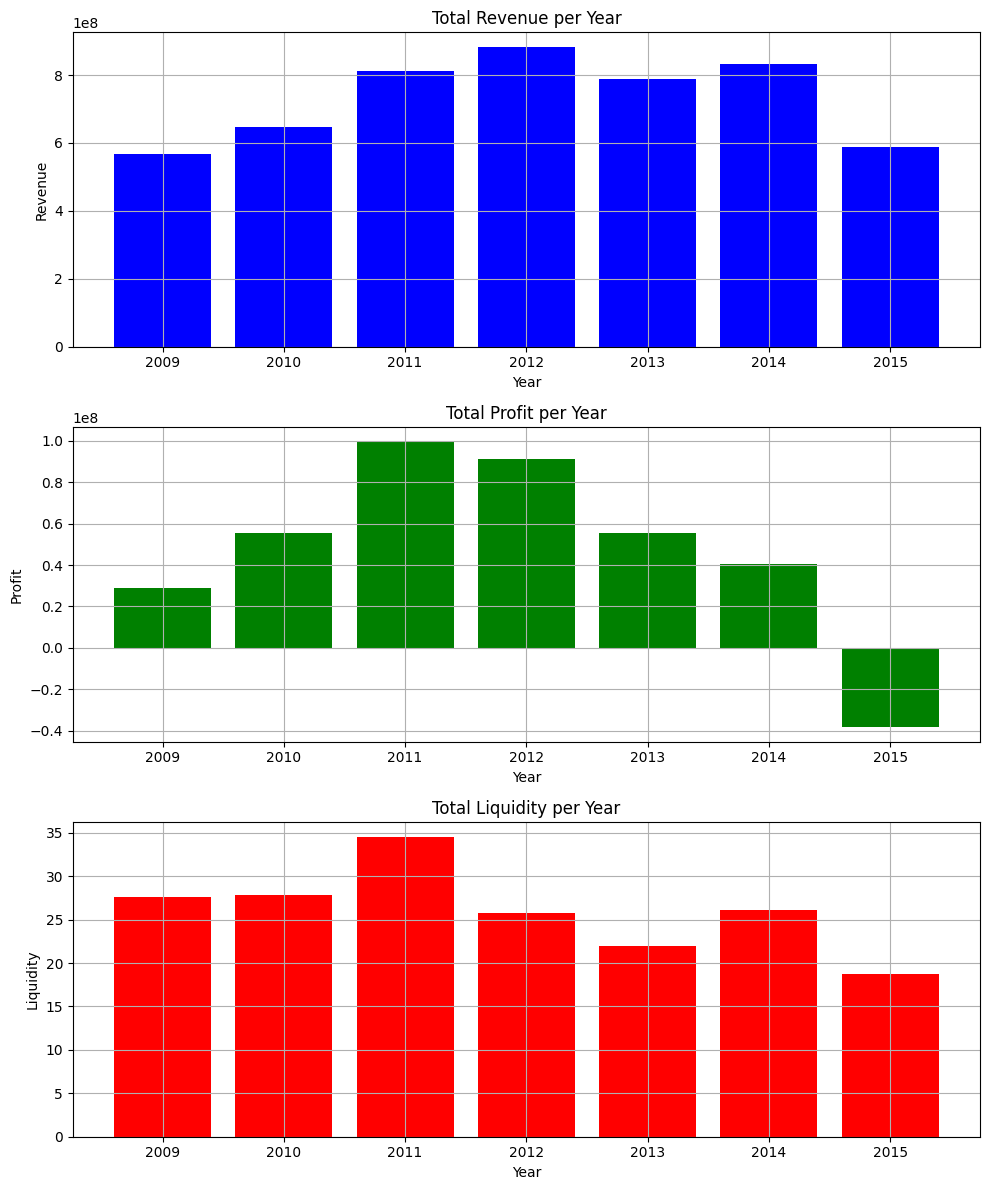

In [439]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 12))

# First subplot: Total Revenue
axes[0].bar(total_revenue_per_year.index, total_revenue_per_year.values, color='blue')
axes[0].set_title('Total Revenue per Year')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Revenue')
axes[0].grid(True)

# Second subplot: Total Profit
axes[1].bar(total_profit_per_year.index, total_profit_per_year.values, color='green')
axes[1].set_title('Total Profit per Year')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Profit')
axes[1].grid(True)

# Third subplot: Average Liquidity
axes[2].bar(total_liquidity_per_year.index, total_liquidity_per_year.values, color='red')
axes[2].set_title('Total Liquidity per Year')
axes[2].set_xlabel('Year')
axes[2].set_ylabel('Liquidity')
axes[2].grid(True)

plt.tight_layout()
plt.show()



- creating a new profit measure (operating result/ sales revenue) and make a bar graph showing which companies had the highest profit margin in 2015. IS there correlation with the firm's size?

Ensure profit and revenue do not contain any zero, NaN or infinite values

In [533]:
adf_OG = adf_OG[adf_OG['operating_income']!=0]

In [534]:
adf_OG['pmargin'] = adf_OG['profit']/adf_OG['operating_income']

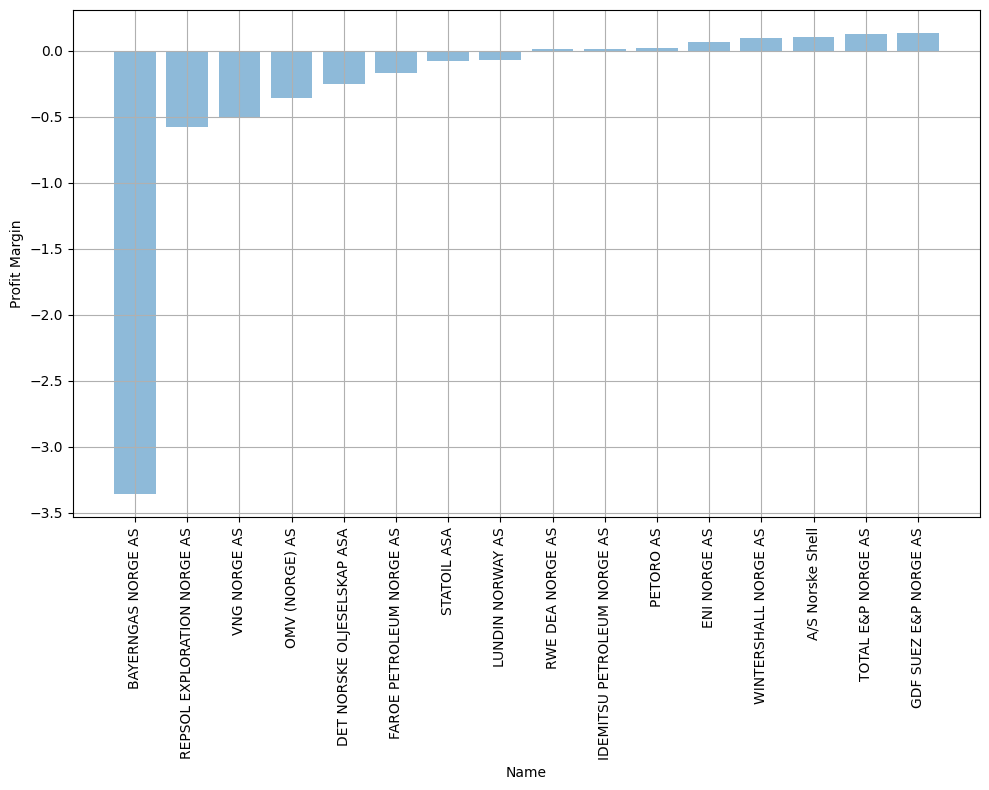

In [444]:
subset_2015 = adf_OG[adf_OG['year'] == 2015].sort_values(by='pmargin', ascending=True)

plt.figure(figsize=(10, 8))
plt.bar(subset_2015['name'], subset_2015['pmargin'], alpha=0.5)
plt.xlabel('Name')
plt.ylabel('Profit Margin')
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()

Next, the profit margin is plotted against total assets

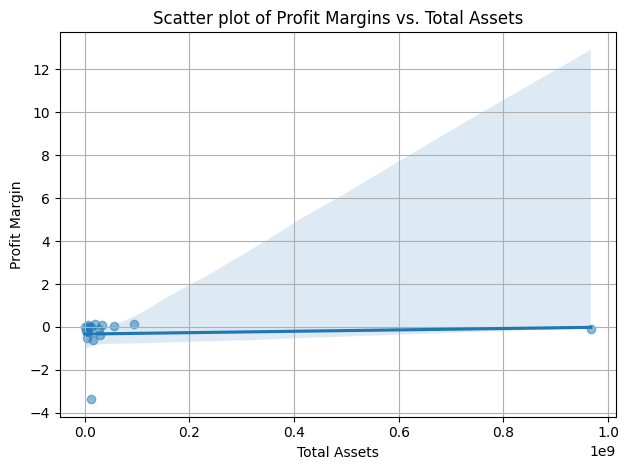

In [445]:

# create scatter plot with smooth curve 
sns.regplot(
    x='total_assets',
    y='pmargin',
    data=subset_2015,
    scatter_kws={'alpha':0.5}
)
plt.xlabel('Total Assets')
plt.ylabel('Profit Margin')
plt.title('Scatter plot of Profit Margins vs. Total Assets')
plt.grid(True)
plt.tight_layout()
plt.show()

Outlier with lowest margin is **BAYERNGAS NORGE AS**

In [456]:
subset_2015.loc[subset_2015['pmargin'].idxmin()]['name']

'BAYERNGAS NORGE AS'

Outlier with most total assets is **STATOIL ASA**, skewing the results

In [454]:
subset_2015.loc[subset_2015['total_assets'].idxmax()]['name']

'STATOIL ASA'

Removing STATOIL ASA, let's see the performance of mid-sized firms on the scatter plot 

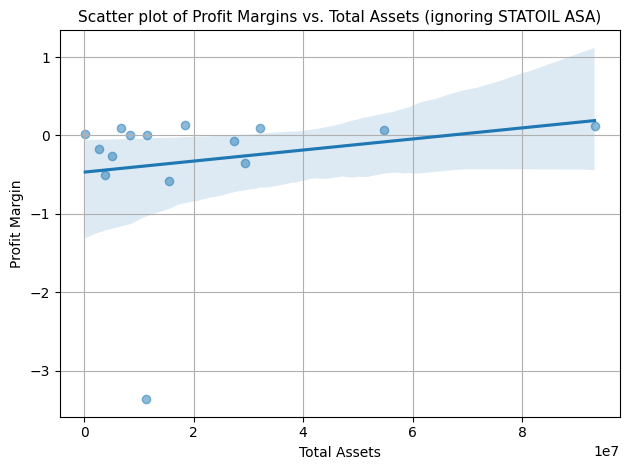

In [459]:
# create scatter plot with smooth curve 
sns.regplot(
    x='total_assets',
    y='pmargin',
    data=subset_2015.drop(subset_2015['total_assets'].idxmax()),
    scatter_kws={'alpha':0.5}
)
plt.xlabel('Total Assets')
plt.ylabel('Profit Margin')
plt.title('Scatter plot of Profit Margins vs. Total Assets (ignoring STATOIL ASA)', fontsize=11)
plt.grid(True)
plt.tight_layout()
plt.show()

The top three firms above approximately 3 billion in total assets seem to be profitable, whereas the majority of smaller firms are not profitable (negative profit margins). It turns we forgot to convert some of the currencies from USD and EUR into NOK, but this will not affect the unit-less profit margin figure.

In [461]:
# verify that all firms within subset_2015 are all denoted in NOK (not USD)
subset_2015['currency_code'].unique()

array(['NOK', 'EUR', 'USD'], dtype=object)

- calculating mean profit margins over time for oil & gas companies

In [470]:
mean_yearly_pmargin = adf_OG.groupby('year')['pmargin'].mean().loc[2010:]

There is only a single data point from 2009 so start beginning from 2010

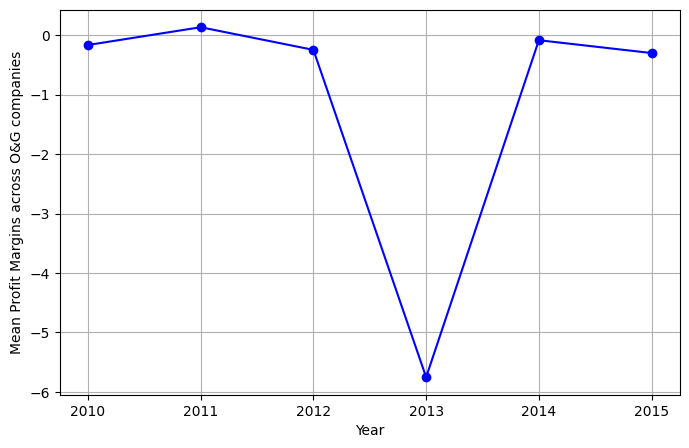

In [472]:
plt.figure(figsize=(8,5))
plt.plot(mean_yearly_pmargin.index, mean_yearly_pmargin.values, marker='o', color='blue')
plt.xlabel('Year')
plt.ylabel('Mean Profit Margins across O&G companies')
plt.grid(True)
plt.show()

- Choose some financial metrics for O&G companies (create some), show how these metrics vary over firms (by charting against another variable for example), show how the metrics vary over time (aggregated e.g. sum, mean etc.), interpret the results by searching for extra information. State of the O&G industry at the time?

In [473]:
adf_OG.columns

Index(['working_capital', 'working_capital_perc', 'fixed_assets', 'long_debt',
       'NACE_desc', 'NACE_code', 'profit', 'other_fin_instr', 'employees',
       'depreciation', 'change_inventories', 'operating_income',
       'operating_costs', 'operating_result', 'equity', 'total_assets',
       'org_type', 'principality', 'debt', 'inv', 'cash', 'municipality',
       'corp_accounts', 'short_debt', 'accounts_receivable', 'director',
       'liquidity', 'wage_costs', 'profitability', 'current_assets',
       'pretax_profit', 'orgnr', 'audit_remarks', 'audit_komments',
       'audit_explanation_txt', 'audit_explanation', 'sales_revenue',
       'solidity', 'status', 'founded_date', 'dividend', 'currency_code',
       'supply_cost', 'inventory', 'year', 'name', 'NACE1', 'NACE2',
       'pmargin'],
      dtype='object')

In [474]:
profit_analysis = adf_OG[['name', 'year', 'operating_result', 'profit', 'pretax_profit', 'profitability', 'depreciation', 'operating_costs', 'operating_income']]

Plot pretax profit vs. profit

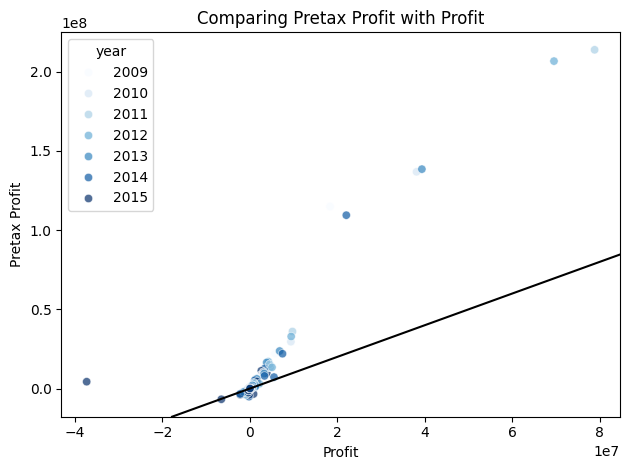

In [476]:
sns.scatterplot(data=profit_analysis, x='profit', y='pretax_profit', hue='year', palette='Blues', alpha=0.7)
plt.axline((0,0), slope=1, color='black', linestyle='-')
plt.xlabel('Profit')
plt.ylabel('Pretax Profit')
plt.title('Comparing Pretax Profit with Profit')
plt.tight_layout()
plt.show()

Plotting operating result (similar to EBIT) with profit 

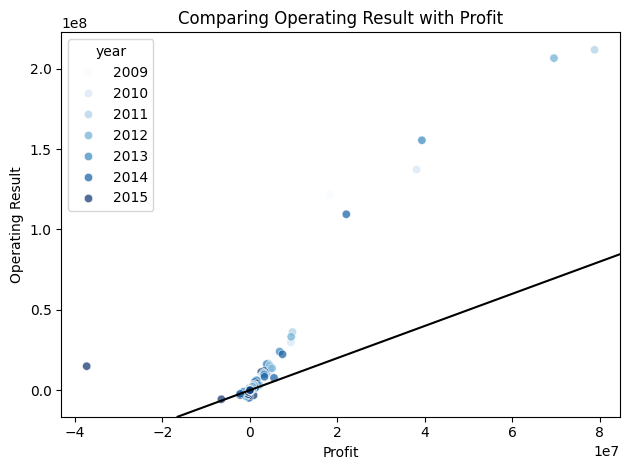

In [478]:
sns.scatterplot(data=profit_analysis, x='profit', y='operating_result', hue='year', palette='Blues', alpha=0.7)
plt.axline((0,0), slope=1, color='black', linestyle='-')
plt.xlabel('Profit')
plt.ylabel('Operating Result')
plt.title('Comparing Operating Result with Profit')
plt.tight_layout()
plt.show()

Regularise the variables by dividing by operating income

In [481]:
# avoid division by zero
profit_analysis = profit_analysis[profit_analysis['operating_income'] != 0]

In [482]:
profit_analysis = profit_analysis.assign(
    profit_margin = profit_analysis['profit']/profit_analysis['operating_income'],
    pretax_profit_margin = profit_analysis['pretax_profit']/profit_analysis['operating_income'],
    operating_margin = profit_analysis['operating_result']/profit_analysis['operating_income']
)

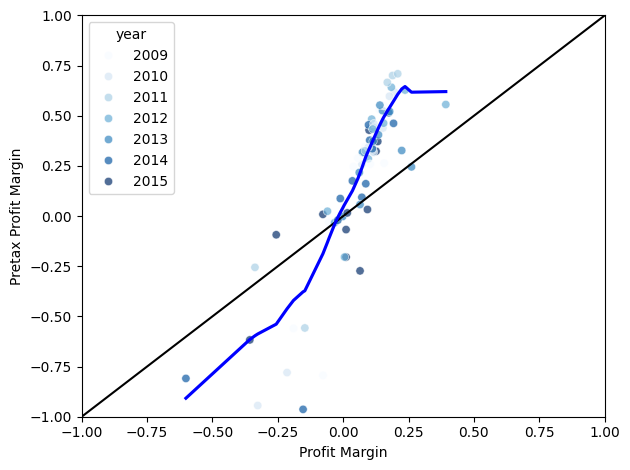

In [487]:
# filter dataset to only include points within the -1 to 1 range due to presence of outliers
filtered_data = profit_analysis[
    (profit_analysis['profit_margin'].between(-1, 1)) &
    (profit_analysis['pretax_profit_margin'].between(-1, 1))
]

# Create the scatter plot of filtered data
ax = sns.scatterplot(
    data=filtered_data, 
    x='profit_margin', 
    y='pretax_profit_margin', 
    hue='year', 
    palette='Blues', 
    alpha=0.7
)

# Add the reference line y=x
plt.axline((0,0), slope=1, color='black', linestyle='-')

# Add the lowess smoothing line using only the filtered data
sns.regplot(
    data=filtered_data,
    x='profit_margin',
    y='pretax_profit_margin',
    lowess=True,
    scatter=False,   # Don't re-plot points
    color='blue',
    ax=ax
)

# Set plot limits
plt.xlim([-1, 1])
plt.ylim([-1, 1])

plt.xlabel('Profit Margin')
plt.ylabel('Pretax Profit Margin')
plt.tight_layout()
plt.show()


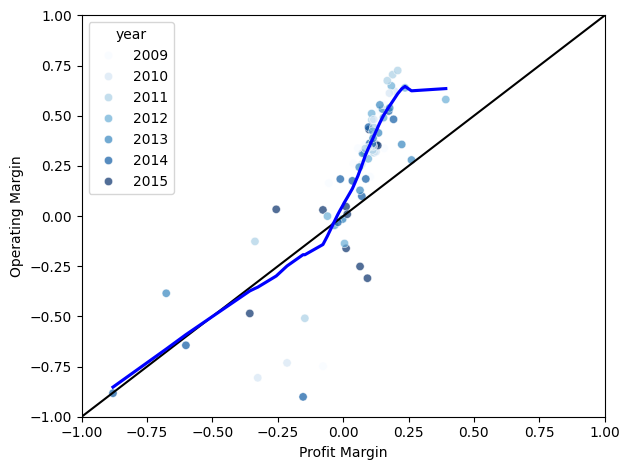

In [488]:
# filter dataset to only include points within the -1 to 1 range due to presence of outliers
filtered_data = profit_analysis[
    (profit_analysis['profit_margin'].between(-1, 1)) &
    (profit_analysis['operating_margin'].between(-1, 1))
]

# Create the scatter plot of filtered data
ax = sns.scatterplot(
    data=filtered_data, 
    x='profit_margin', 
    y='operating_margin', 
    hue='year', 
    palette='Blues', 
    alpha=0.7
)

# Add the reference line y=x
plt.axline((0,0), slope=1, color='black', linestyle='-')

# Add the lowess smoothing line using only the filtered data
sns.regplot(
    data=filtered_data,
    x='profit_margin',
    y='operating_margin',
    lowess=True,
    scatter=False,   # Don't re-plot points
    color='blue',
    ax=ax
)

# Set plot limits
plt.xlim([-1, 1])
plt.ylim([-1, 1])

plt.xlabel('Profit Margin')
plt.ylabel('Operating Margin')
plt.tight_layout()
plt.show()

We have removed the influenced of outliers by restricting data points to those falling within the (-1, 1) square. The S-shape centred around the slope 1 line could point to the following effect. 

Firms with large, positive operating margins have much smaller profit margins because of taxes, interest payment expenses the profit margin incorporates for profitable firms. However, we see that points lying on the bottom left corner where both operating and profit margins are negative, points representing non-profitable firms lie closer to the line. Most of these points lie below the line meaning they recoup some of their losses from taxes or government incentives. 

This may indicate that the tax system could reduce the positive profit margin and lessens the negative profit margins of non-profitable firms. The Norwegian government provides an effective subsidy to loss-making firms. This matches the objectives set out by tax-neutrality laws. 

Let's now aggregate the results over all the years under consideration and take the mean of these margins. 

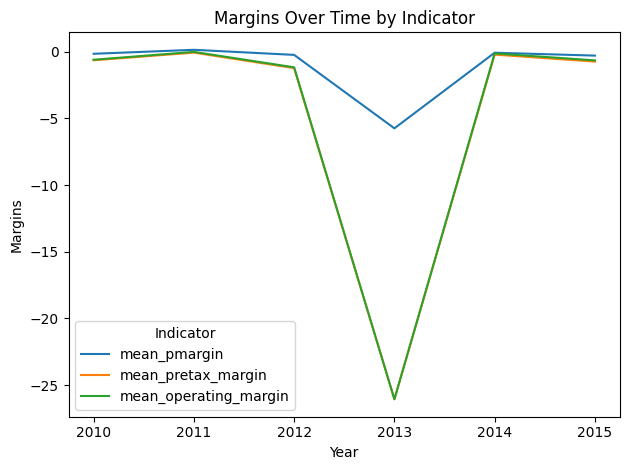

In [494]:
profit_agg = profit_analysis.groupby('year').agg(
    mean_pmargin = ('profit_margin', 'mean'),
    mean_pretax_margin = ('pretax_profit_margin', 'mean'),
    mean_operating_margin = ('operating_margin', 'mean')
)

profit_agg_long = profit_agg.reset_index().melt( # make 'year' a column again, not index
    id_vars='year',
    var_name='Indicator',
    value_name='Margins'
)

sns.lineplot(
    data=profit_agg_long[profit_agg_long['year']>2009],
    x='year',
    y='Margins',
    hue='Indicator'
)

plt.xlabel('Year')
plt.ylabel('Margins')
plt.title('Margins Over Time by Indicator')
plt.tight_layout()
plt.show()

Could use `jitter` to differentiate between `mean_pretax_margin` and `mean_operating_margin`, which are practically equivalent and this cannot be distinguised on the line plot.  

Ideas:

1. Compare their average profits or pre-tax profits with Brent or natural gas prices benchmarks (correlation analysis)
2. Comparing margins pre- and post-industry events 
3. Study concentration vs. diversification: check whether the yearly profits are coming from more or fewer firms, do a handful of players increasingly dominate? what percentage of total industry profit the top 5 or top 10 firms represent?
4. how operating costs and sales_revenue evolve over time, and their ratio. Do companies get better at controlling costs when revenue falls? 

The top 5 companies are chosen each year based on their *yearly* profit. We want to understand the percentage of yearly profits contributed by these top firms over time. This may be helpful in capturing whether concentration or diversification is taking place. This may be studied with respect to other factors, such as production of crude abroad, prices, geographical spreads, costs etc. 

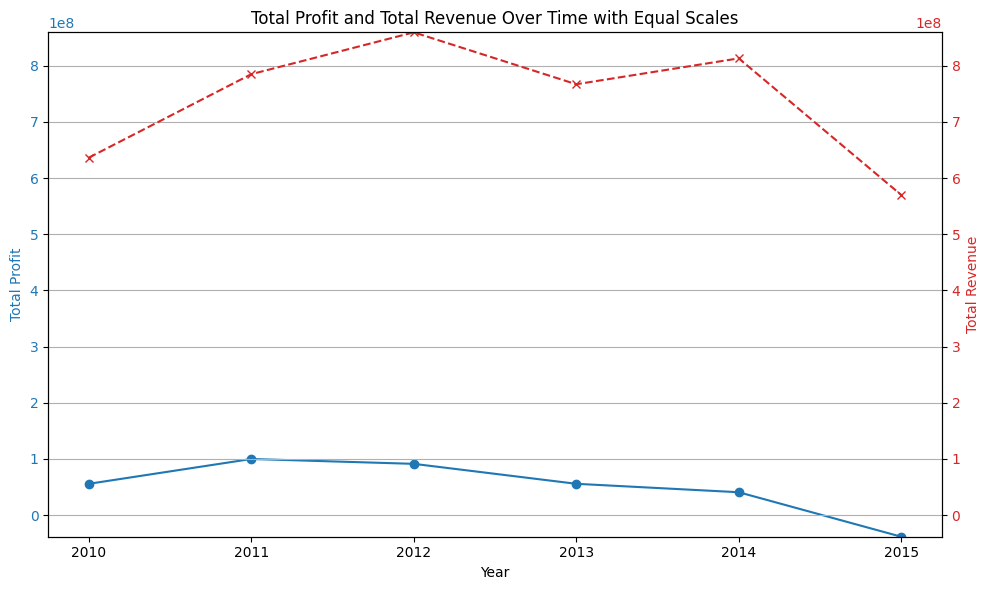

In [515]:
total_yearly_profits = profit_analysis.reset_index().groupby('year').agg(
    total_profit=('profit', 'sum')
).iloc[1:] # get rid of 2009 single data point row 

# `profit_analysis` does not contain any revenu-related columns, so use `adf_OG` instead
total_sales_revenue = adf_OG.reset_index().groupby('year').agg(
    total_revenue=('sales_revenue', 'sum')
).iloc[1:] # get rid of 2009 single data point row

# Find the global min and max across both datasets for equal scaling
y_min = min(total_yearly_profits['total_profit'].min(), total_sales_revenue['total_revenue'].min())
y_max = max(total_yearly_profits['total_profit'].max(), total_sales_revenue['total_revenue'].max())

# Create the plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# First y-axis for total profits
ax1.plot(total_yearly_profits.index, total_yearly_profits['total_profit'], color='tab:blue', marker='o', label='Total Profit')
ax1.set_xlabel('Year')
ax1.set_ylabel('Total Profit', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_ylim(y_min, y_max)  # Set the same y-axis scale

# Create a second y-axis
ax2 = ax1.twinx()
ax2.plot(total_sales_revenue.index, total_sales_revenue['total_revenue'], color='tab:red', linestyle='--', marker='x', label='Total Revenue')
ax2.set_ylabel('Total Revenue', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.set_ylim(y_min, y_max)  # Set the same y-axis scale

# Add title, grid, and legend
plt.title('Total Profit and Total Revenue Over Time with Equal Scales')
fig.tight_layout()
plt.grid(True)

# Show the plot
plt.show()


From 2013 to 2014, total profit is slightly down, yet total revenue appears to be up yoy. 

Total profits have been on a steady decline from 2011 to 2015

2015 is negative profits for the oil and gas industry overall... so if we divide positive returns for top 5 firms by negative industry returns, this will not be a share... perhaps operating income is a better measure but let us try both and discuss.

We can see that `STATOIL ASA` has the largest share of `sales_revenue` by far. we can simply show the share of profits of the biggest firm against the share of all other competitors combined.

In [550]:
adf_OG.groupby('name')['sales_revenue'].sum().sort_values(ascending=False).head()

name
STATOIL ASA             4.031325e+09
TOTAL E&P NORGE AS      2.954890e+08
A/S Norske Shell        2.736140e+08
ENI NORGE AS            1.230874e+08
WINTERSHALL NORGE AS    8.057600e+07
Name: sales_revenue, dtype: float64

/var/folders/g2/l186zykd1g56mc9vp1p2rv280000gn/T/ipykernel_27010/2740211706.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  profit_analysis = profit_analysis.groupby('year').apply(classify_top5)


    year category      profit
0   2009     Rest  10780424.0
1   2009     Top5  18313000.0
2   2010     Rest  17614526.0
3   2010     Top5  38082000.0
4   2011     Rest  21095346.0
5   2011     Top5  78787000.0
6   2012     Rest  21751874.0
7   2012     Top5  69500000.0
8   2013     Rest  16419989.0
9   2013     Top5  39300000.0
10  2014     Rest  18678738.0
11  2014     Top5  22022000.0
12  2015     Rest -42333204.0
13  2015     Top5   3830000.0


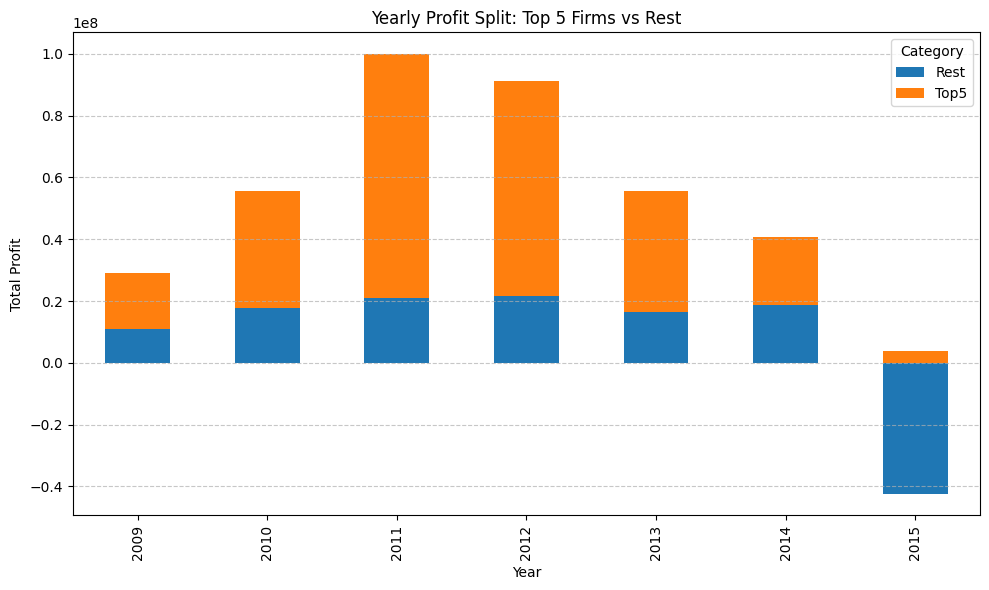

In [549]:
profit_analysis = adf_OG[['name', 'year', 'operating_result', 'profit', 'pretax_profit', 'profitability', 'depreciation', 'operating_costs', 'operating_income']]

profit_analysis = profit_analysis[profit_analysis['operating_income']!=0]

def classify_top5(group):
    top_5_firms = group.nlargest(1, 'profit')['name'].tolist()
    group['category'] = group['name'].apply(lambda x: 'Top5' if x in top_5_firms else 'Rest')
    return group

# classify top5 profitable firms for each year by creating a 'category' column in `profit_analysis`
profit_analysis = profit_analysis.groupby('year').apply(classify_top5)

profit_analysis = profit_analysis.reset_index(drop=True)

# aggregate total profit for 'top5' and 'Rest' per year 
top5_rest = profit_analysis.groupby(['year', 'category'], as_index=False)['profit'].sum()
print(top5_rest)

# pivot for stacked bar chart
pivot_data = top5_rest.pivot(index='year', columns='category', values='profit').fillna(0)

# plot the stacked bar chart
fig, ax = plt.subplots(figsize=(10,6))
pivot_data.plot(kind='bar', stacked=True, ax=ax, color=['tab:blue', 'tab:orange'])

# Add labels and titles
plt.title('Yearly Profit Split: Top 5 Firms vs Rest')
plt.xlabel('Year')
plt.ylabel('Total Profit')
plt.legend(title='Category')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

/var/folders/g2/l186zykd1g56mc9vp1p2rv280000gn/T/ipykernel_27010/1841592108.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rev_per_categ = rev_per_categ.groupby('year').apply(classify_top1)


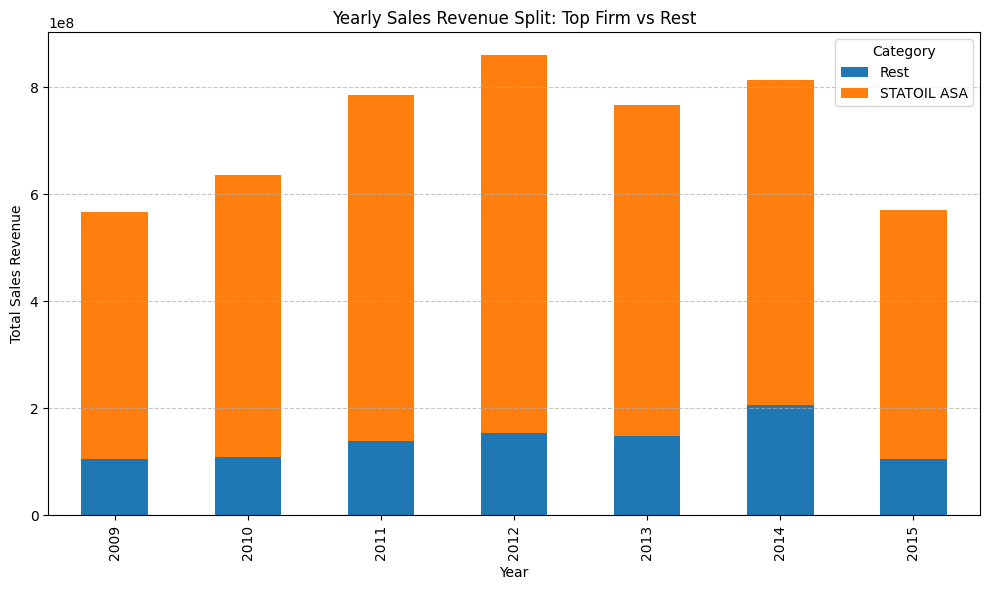

In [551]:
#profit_analysis = adf_OG[['name', 'year', 'operating_result', 'profit', 'pretax_profit', 'profitability', 'depreciation', 'operating_costs', 'operating_income']]
rev_per_categ = adf_OG.copy()
#profit_analysis = profit_analysis[profit_analysis['operating_income']!=0]
rev_per_categ = rev_per_categ[rev_per_categ['sales_revenue']!=0]

def classify_top1(group):
    top_1_firms = group.nlargest(1, 'sales_revenue')['name'].tolist()
    group['category'] = group['name'].apply(lambda x: 'STATOIL ASA' if x in top_1_firms else 'Rest')
    return group

# classify top revenue firm for each year by creating a 'category' column in `profit_analysis`
rev_per_categ = rev_per_categ.groupby('year').apply(classify_top1)
rev_per_categ = rev_per_categ.reset_index(drop=True)

# aggregate total profit for 'top5' and 'Rest' per year 
top5_rest = rev_per_categ.groupby(['year', 'category'], as_index=False)['sales_revenue'].sum()

# pivot for stacked bar chart
pivot_data = top5_rest.pivot(index='year', columns='category', values='sales_revenue').fillna(0)

# plot the stacked bar chart
fig, ax = plt.subplots(figsize=(10,6))
pivot_data.plot(kind='bar', stacked=True, ax=ax, color=['tab:blue', 'tab:orange'])

# Add labels and titles
plt.title('Yearly Sales Revenue Split: Top Firm vs Rest')
plt.xlabel('Year')
plt.ylabel('Total Sales Revenue')
plt.legend(title='Category')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

1. Look into why revenue is up from 2013 to 2014 but profit is down:
- increase in operating costs?
- decline in operating efficiency?
- compare `pretax_profit` and `profit`, write-offs, restructuring costs, regulatory fines or legal expenses?
- change in product or service mix? 
- depreciation or interest costs? 
- look into whether fall in profitability is correlated with the firms's size? 

In [556]:
import yfinance as yfin
ticker = 'CL=F'
ticker = yfin.Ticker(ticker)
df = ticker.history(start='2010-01-01', end='2016-01-01')

In [557]:
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2010-01-04 00:00:00-05:00,79.629997,81.680000,79.629997,81.510002,263542,0.0,0.0
2010-01-05 00:00:00-05:00,81.629997,82.000000,80.949997,81.769997,258887,0.0,0.0
2010-01-06 00:00:00-05:00,81.430000,83.519997,80.849998,83.180000,370059,0.0,0.0
2010-01-07 00:00:00-05:00,83.199997,83.360001,82.260002,82.660004,246632,0.0,0.0
2010-01-08 00:00:00-05:00,82.650002,83.470001,81.800003,82.750000,310377,0.0,0.0


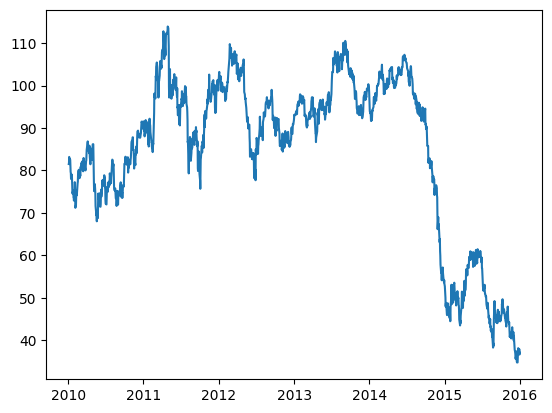

In [560]:
plt.plot(df.index, df['Close'])
plt.show()

In [561]:
df = df['Close'].resample('Y').mean()
df.index = df.index.year
df.head()

/var/folders/g2/l186zykd1g56mc9vp1p2rv280000gn/T/ipykernel_27010/3100451543.py:1: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df = df['Close'].resample('Y').mean()


Date
2010    79.609881
2011    95.114405
2012    94.213520
2013    98.046825
2014    92.906786
Name: Close, dtype: float64

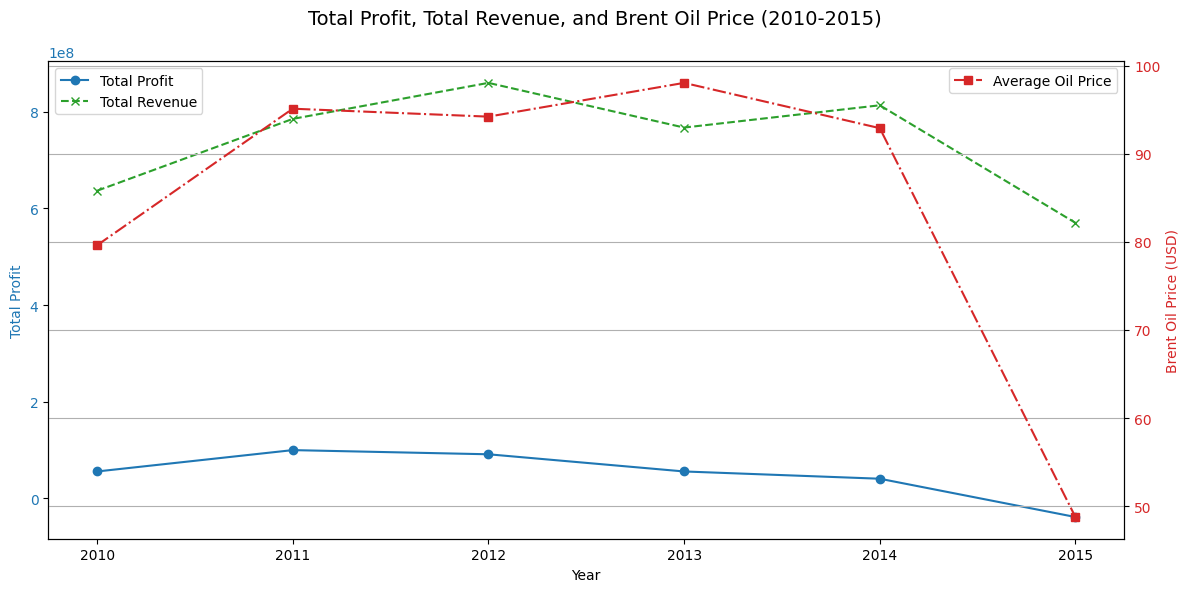

Correlation Matrix:
               Total Profit  Total Revenue  Oil Price
Total Profit       1.000000       0.768428   0.877464
Total Revenue      0.768428       1.000000   0.880570
Oil Price          0.877464       0.880570   1.000000


In [562]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot total profits on the first y-axis
ax1.plot(total_yearly_profits.index, total_yearly_profits['total_profit'], 
         color='tab:blue', marker='o', label='Total Profit')
ax1.set_xlabel('Year')
ax1.set_ylabel('Total Profit', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Plot total revenues on the first y-axis
ax1.plot(total_sales_revenue.index, total_sales_revenue['total_revenue'], 
         color='tab:green', linestyle='--', marker='x', label='Total Revenue')

# Add second y-axis for oil prices
ax2 = ax1.twinx()
ax2.plot(df.index, df.values, 
         color='tab:red', linestyle='-.', marker='s', label='Average Oil Price')
ax2.set_ylabel('Brent Oil Price (USD)', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Titles, legends, and grid
fig.suptitle('Total Profit, Total Revenue, and Brent Oil Price (2010-2015)', fontsize=14)
fig.tight_layout()
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.grid(True)
plt.show()

# Step 5: Correlation Analysis
merged_data = pd.DataFrame({
    'Total Profit': total_yearly_profits['total_profit'],
    'Total Revenue': total_sales_revenue['total_revenue'],
    'Oil Price': df
}).dropna()

# Calculate correlation matrix
correlation_matrix = merged_data.corr()
print("Correlation Matrix:")
print(correlation_matrix)

Total revenue and total profit appear to have a very similar correlation with the Brent oil price, so other factors may be better at explaining the disrepancy between revenue and profit. 

- `Equity` represents the residual interest in the assets of the company, after deducting liabilities. It reflects the ownership stake of shareholders and includes retained earnings, paid-in capital, and other reserves.

Retained earnings are profits reinvested into the company rather than distributed as dividends or used as buybacks. Share capital is the initial and subsequent equity raised from shareholders. In oil firms, exploration and drilling require significant investments upfront. This impacts equity as retained earnings may be reinvested to fund capital projects. Firms may issue equity to fund large projects, especially when oil prices are volatile or debt financing is risky. Share buybacks reduce equity as cash is used to repirchase shares, decreasing retained earnings. 

- `Cash` represents the liquid assets that the company holds, e.g. bank balances, marketable securities readily available for operational, investment or distribution processes. 

Operating cash-flow is cash generated from day-to-day operations, such as oil production and sales. Free cash flow is remaining cash after accouting for capital expenditures, used for dividends, buybacks, or debt repayment. In oil firms, cash is used to fund high-risk capital-intensive drilling projects. Low cash reserves may indicate reduced investment in exploration or a reliance on external funding. High cash reserves often prompt shareholder returns through dividends or buybacks, especially when oil prices are high and there is limited room for production growth. 

- `Debt` represents the total liabilities a company owes (incld. loans, bonds, credit instruments). Short-term debt are often used to meet operational needs. Long-term debt are bonds or loans maturing over multiple years, used to finance large-scale exploration and production projects. 

In oil firms, long-term debt funds projects, as opposed to issuing equity, particularly when rates are low. This avoids diluting shareholder ownership but increases financial risk, especially if oil prices decline.
During peiods of high oil prices, firms may use excess cash flow to reduce debt, to help meet debt obligations during downturns. 

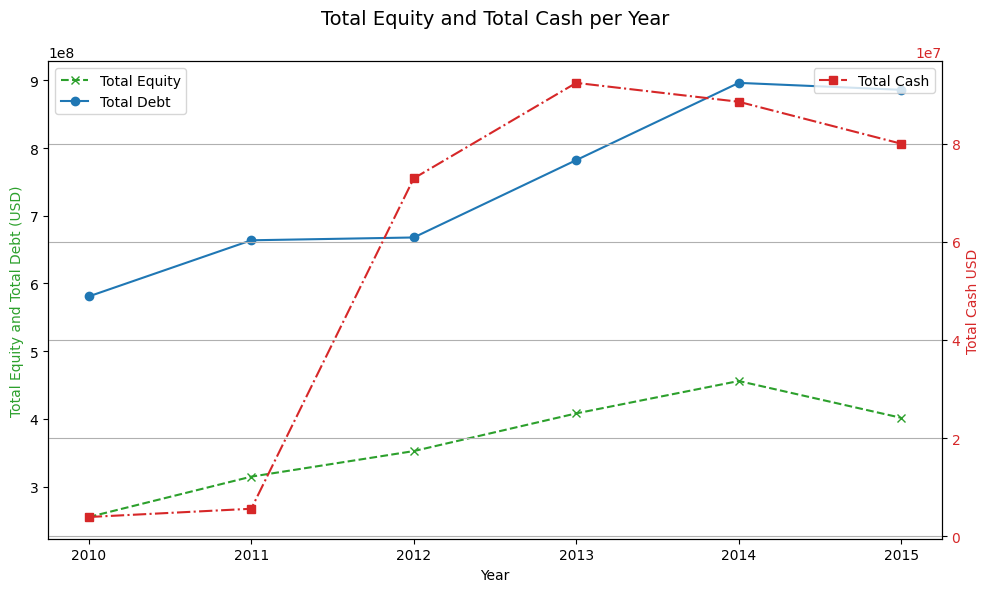

In [26]:
buyback_analysis = adf_OG.groupby('year').agg(
    total_equity=('equity', 'sum'),
    total_cash=('cash', 'sum'),
    total_debt=('debt', 'sum')
)

fig, ax1 = plt.subplots(figsize=(10,6))

# Plot total revenues on the first y-axis
ax1.plot(buyback_analysis.iloc[1:].index, buyback_analysis.iloc[1:]['total_equity'], 
         color='tab:green', linestyle='--', marker='x', label='Total Equity')

ax1.plot(buyback_analysis.iloc[1:].index, buyback_analysis.iloc[1:]['total_debt'], 
         color='tab:blue', linestyle='-', marker='o', label='Total Debt')

ax1.set_ylabel('Total Equity and Total Debt (USD)', color='tab:green')
ax1.set_xlabel('Year')

# Add second y-axis for oil prices
ax2 = ax1.twinx()
ax2.plot(buyback_analysis.iloc[1:].index, buyback_analysis.iloc[1:]['total_cash'], 
         color='tab:red', linestyle='-.', marker='s', label='Total Cash')
ax2.set_ylabel('Total Cash USD', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Titles, legends, and grid
fig.suptitle('Total Equity and Total Cash per Year', fontsize=14)
fig.tight_layout()
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.grid(True)
plt.show()